# Spaceship Titanic

Predict which passengers are transported to an alternate dimension

- Current Rank: 1474/2224 (Top 66%)
- Current Score: 0.79284 / Best Score: 0.82066

### File and Data Field Descriptions

<details>
<summary>Click to expand</summary>

train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
+ PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the 
group. People in a group are often family members, but not always.
+ HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
+ CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
+ Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
+ Destination - The planet the passenger will be debarking to.
+ Age - The age of the passenger.
+ VIP - Whether the passenger has paid for special VIP service during the voyage.
+ RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
+ Name - The first and last names of the passenger.
+ Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

+ test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
sample_submission.csv - A submission file in the correct format.
+ PassengerId - Id for each passenger in the test set.
+ Transported - The target. For each passenger, predict either True or False.

</details>

In [19]:
from datetime import datetime as time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from Kaggle.Challenges.utils import make_mi_scores, plot_mi_scores
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
import optuna
import seaborn as sns

In [ ]:
class EarlyStoppingCallback:
    """
    Early stopping callback for Optuna studies.
    Stops the study if there is no improvement in the best value for a specified number of trials (patience).
    """
    def __init__(self, patience: int, min_delta: float = 0.0):
        """
        Args:
            patience (int): Number of trials to wait for improvement before stopping.
            min_delta (float): Minimum change in the monitored value to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_value = None

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial):
        if self.best_value is None:
            self.best_value = study.best_value
            return

        if study.direction == optuna.study.StudyDirection.MINIMIZE:
            if study.best_value < self.best_value - self.min_delta:
                self.best_value = study.best_value
                self.counter = 0
            else:
                self.counter += 1
        else:
            if study.best_value > self.best_value + self.min_delta:
                self.best_value = study.best_value
                self.counter = 0
            else:
                self.counter += 1

        if self.counter >= self.patience:
            study.stop()
            print(f'Early stopping triggered after {self.counter} trials with no improvement.')

In [2]:
dtype={
    'Age': 'float32',
    'RoomService': 'float32',
    'FoodCourt': 'float32',
    'ShoppingMall': 'float32',
    'Spa': 'float32',
    'VRDeck': 'float32'}

In [3]:
# Importing the dataset
train = pd.read_csv('data/space/train.csv', index_col='PassengerId', dtype=dtype)
test = pd.read_csv('data/space/test.csv', index_col='PassengerId', dtype=dtype)

In [4]:
def feature_engineering(df: pd.DataFrame):
    
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['CryoSleep'] = df['CryoSleep'].fillna(False)
    df['Cabin'] = df['Cabin'].fillna('U/0/U')
    df['RoomService'] = df['RoomService'].fillna(0)
    df['FoodCourt'] = df['FoodCourt'].fillna(0)
    df['ShoppingMall'] = df['ShoppingMall'].fillna(0)
    df['Spa'] = df['Spa'].fillna(0)
    df['VRDeck'] = df['VRDeck'].fillna(0)
    df['TotalServicesFee'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df['Num'] = df['Num'].astype(int)
    
    df = df.drop('Cabin', axis=1)
    
    cols = [
        'Name',
        'VIP',
        'Destination',
        'HomePlanet',
        'Side'
    ]
    
    df = df.drop(cols, axis=1)
    
    # Transform boolean columns to integer
    bool_col = df.select_dtypes(include=['bool']).columns
    df[bool_col] = df[bool_col].astype(int)
    
    ordinal_encoder = OrdinalEncoder()
    cat_columns = df.select_dtypes(include=[str]).columns
    df[cat_columns] = ordinal_encoder.fit_transform(df[cat_columns])
    
    return df

In [5]:
transformed_train = feature_engineering(train)

In [6]:
X = transformed_train.drop('Transported', axis=1)
y = transformed_train['Transported']

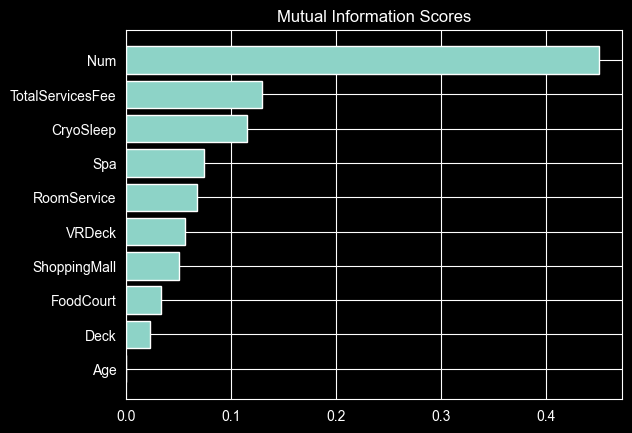

In [7]:
# Investigate MI of data
discrete_features = X.dtypes == int # All discrete features should now have integer dtypes (double-check this before using MI!)
mi_scores = make_mi_scores(X, y, discrete_features)
plot_mi_scores(mi_scores)

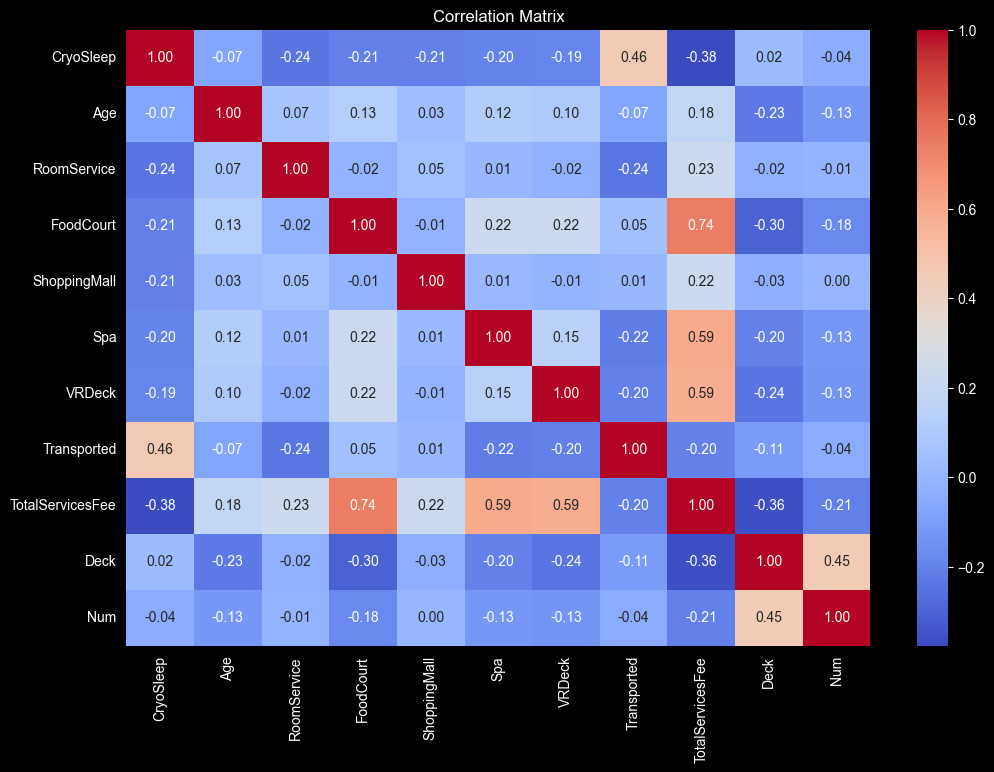

In [8]:

# Correlation matrix
corr = transformed_train.corr()
plt.figure(figsize=(12, 8))
plt.title('Correlation Matrix')
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

In [9]:
# prepare data for model
random_state = int(time.now().timestamp()) % 4294967295
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=random_state)

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

TotalServicesFee    0.196398
Deck                0.129086
CryoSleep           0.115614
Spa                 0.102739
FoodCourt           0.090859
Num                 0.085245
VRDeck              0.084696
RoomService         0.075087
Age                 0.061011
ShoppingMall        0.059265
dtype: float64


<Axes: >

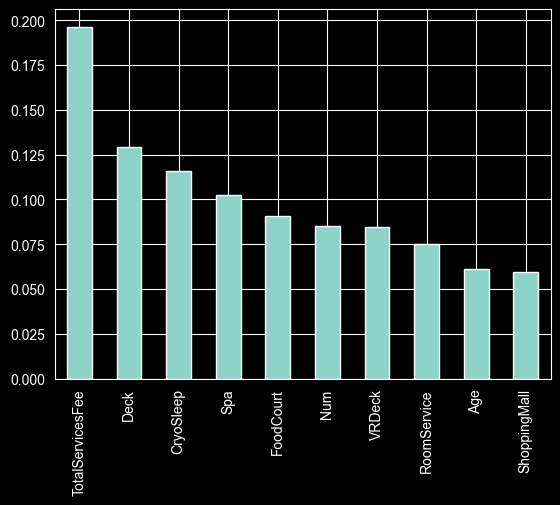

In [10]:
# Tune model
params = {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
model = RandomForestClassifier(**params)
model.fit(X_train, y_train)
important_features = pd.Series(data=model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(important_features)
important_features.plot(kind='bar')

In [ ]:
train_prediction = model.predict(X_test)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv) # Use cross-validation to estimate performance


print('Accuracy Score:', accuracy_score(y_test,train_prediction)) # 0.799 % Accuracy
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}") # Mean Cross-validation score 0.79 % Accuracy

# Use Optuna to Tune Params

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
    }

    model = RandomForestClassifier(**params, random_state=random_state)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    return cv_scores.mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Visualize Optuna Results

In [ ]:
# Create a Voting Classifier with the best models
best_rf_params = {'n_estimators': 261, 'max_depth': 21, 'min_samples_split': 11, 'min_samples_leaf': 12, 'criterion': 'gini'}
best_gb_params = {'n_estimators': 98, 'learning_rate': 0.07, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 13, 'subsample': 0.6}
best_knn_params = {'n_neighbors': 44, 'leaf_size': 17, 'weights': 'uniform', 'metric': 'minkowski'}

rf_model = RandomForestClassifier(**best_rf_params, random_state=random_state)
gb_model = GradientBoostingClassifier(**best_gb_params, random_state=random_state)
knn_model = KNeighborsClassifier(**best_knn_params)

voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('gb', gb_model),
        ('knn', knn_model)
    ],
    voting='soft'
)

voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)
voting_accuracy = accuracy_score(y_test, voting_pred)
print(f'Voting Classifier Accuracy: {voting_accuracy:.4f}')

In [ ]:

param_grid = {
    'voting': ['hard', 'soft'],
    'weights': [[1, 1, 1], [2, 1, 1], [1, 2, 1], [1, 1, 2]]
}



grid_search = GridSearchCV(estimator=voting_clf,
                           param_grid=param_grid,
                           cv=cv,
                           n_jobs=-1,
                           verbose=1,
                           scoring='accuracy',
                           return_train_score=False)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Model: {best_model}')
print(f'Best Score: {best_score}')

In [ ]:
# Fitting 5 folds for each of 8 candidates, totalling 40 fits
# Best Parameters: {'voting': 'hard', 'weights': [1, 2, 1]}
# Best Model: VotingClassifier(estimators=[('rf',
#                               RandomForestClassifier(max_depth=21,
#                                                      min_samples_leaf=12,
#                                                      min_samples_split=11,
#                                                      n_estimators=261,
#                                                      random_state=1769366215)),
#                              ('gb',
#                               GradientBoostingClassifier(learning_rate=0.07,
#                                                          max_depth=4,
#                                                          min_samples_leaf=13,
#                                                          min_samples_split=15,
#                                                          n_estimators=98,
#                                                          random_state=1769366215,
#                                                          subsample=0.6)),
#                              ('knn',
#                               KNeighborsClassifier(leaf_size=17,
#                                                    n_neighbors=44))],
#                  weights=[1, 2, 1])
# Best Score: 0.8032788377493547

In [ ]:
# Prepare test data and make predictions
transformed_test = feature_engineering(test)
test_predictions = best_model.predict(transformed_test)

In [ ]:
y_pred = pd.Series(test_predictions, index=test.index, name='Transported')
submission = y_pred.astype(bool).to_frame().reset_index()

In [ ]:
submission.to_csv('data/space/submission.csv', index=False)